# Initialization

In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, r_regression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin\Rscript'
from cdt.independence.graph import Glasso
from cdt.causality.graph import GES

import warnings
warnings.filterwarnings('ignore')

# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)

C:\Users\prata\miniconda3\envs\default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
def load_data(url):
    df = pd.read_csv(url, index_col=0)
    X = df.loc[:, df.columns != 'Churn Value']
    y = df.loc[:, df.columns == 'Churn Value']
    return df, X, y

df_train, X_train, y_train = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/train_data.csv')
df_test, X_test, y_test = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/test_data.csv')

# Causal Discovery

Define features and outcomes

In [3]:
features = X_train.columns.tolist()
outcomes = y_train.columns.tolist()

Discover causal structures

In [4]:
glasso = Glasso()
skeleton = glasso.predict(df_train)
# skeleton.remove_edges_from(nx.selfloop_edges(skeleton))

model = GES()
model_graph = model.predict(df_train, skeleton)

In [5]:
relevant_features = set()
relevant_nodes = set()
relevant_edges = set()

for feature in features:
    for outcome in outcomes:
        if model_graph.has_edge(feature, outcome):
            relevant_features.add(feature)
            relevant_nodes.add(feature)
            relevant_nodes.add(outcome)
            relevant_edges.add((feature, outcome))

n_features = len(relevant_features)
            
print(f'# of relevant features: {n_features}\n')
for feature in sorted(relevant_features):
    print(feature)

# of relevant features: 7

Multiple Lines_No
Online Backup_No
Online Security_No
Payment Method_Electronic check
Senior Citizen_No
Tenure Months
Total Charges


Draw the causal graph

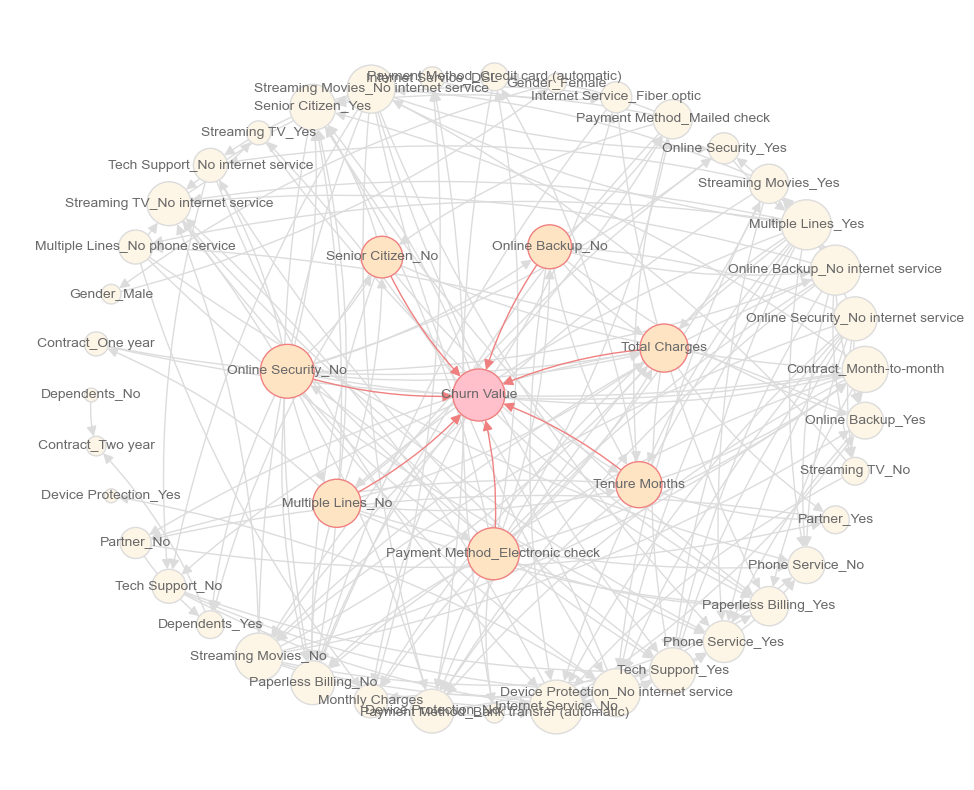

In [6]:
fig = plt.figure(figsize=(10, 8))
    
# model_graph.remove_nodes_from(list(set(features) - (set(outcomes) | set(relevant_features))))

degrees = model_graph.degree()
node_colors = ['pink' if node in outcomes else 'bisque' if node in relevant_features else 'oldlace' for node in model_graph.nodes]
node_sizes = [max(v, 1) * 100 for k, v in degrees]
node_edge_colors = ['lightcoral' if node in relevant_nodes else 'gainsboro' for node in model_graph.nodes]
edge_colors = ['lightcoral' if edge in relevant_edges else 'gainsboro' for edge in model_graph.edges]
pos = nx.shell_layout(model_graph, [outcomes, relevant_features, list(set(features) - set(relevant_features))])

# draw the graph
nodes = nx.draw_networkx_nodes(model_graph,
                               pos=pos,
                               node_color=node_colors,
                               node_size=node_sizes,
                               edgecolors=node_edge_colors)

edges = nx.draw_networkx_edges(model_graph,
                               pos=pos,
                               connectionstyle="arc3,rad=0.1",
                               node_size=node_sizes,
                               edge_color=edge_colors,
                               arrowsize=15)

labels = nx.draw_networkx_labels(model_graph,
                                 pos,
                                 font_size=10,
                                 font_color='dimgray',
                                 clip_on=False)

# bring relevant edges to the top
edge_list = list(model_graph.edges)
edge_index = [edge_list.index(x) for x in relevant_edges]
for i, edge in enumerate(edges):
    if i in edge_index:
        edge.set_zorder(1)
    else:
        edge.set_zorder(0)

# plot the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('images/graph.png', dpi=300)

# Evaluation

In [7]:
def evaluate(clf, x, y, model, features):
    y_pred = clf.predict(x)
    
    accuracy = accuracy_score(y, y_pred)
    bal_accuracy = balanced_accuracy_score(y, y_pred)
    precision_0 = precision_score(y, y_pred, pos_label=1)
    precision_1 = precision_score(y, y_pred, pos_label=0)
    recall_0 = recall_score(y, y_pred, pos_label=1)
    recall_1 = recall_score(y, y_pred, pos_label=0)
    f1_0 = f1_score(y, y_pred, pos_label=1)
    f1_1 = f1_score(y, y_pred, pos_label=0)

    metrics_df.loc[len(metrics_df.index)] = [model, features, accuracy, bal_accuracy, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1]
    
    return y_pred

In [8]:
def evaluateKNN(x_train, x_test, model, features):
    # randomized search with cross-validation
    distributions = dict(n_neighbors=np.linspace(5, 40, num=8, dtype=int),
                         weights=['uniform', 'distance'],
                         metric=['l1', 'l2', 'cosine'])
    knn = KNeighborsClassifier()
    clf = RandomizedSearchCV(knn, distributions, random_state=seed, n_jobs=-1)
    search = clf.fit(x_train, y_train)
    
    # optimal parameters
    n_neighbors = search.best_params_['n_neighbors']
    weights = search.best_params_['weights']
    metric = search.best_params_['metric']

    # test
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    knn.fit(x_train, y_train)
    y_pred = evaluate(knn, x_test, y_test, model, features)

    return y_pred

In [9]:
def evaluateLR(x_train, x_test, model, features):
    # randomized search with cross-validation
    distributions = dict(C=np.logspace(-3, 0, num=10))
    lr = LogisticRegression(random_state=seed)
    clf = RandomizedSearchCV(lr, distributions, random_state=seed, n_jobs=-1)
    search = clf.fit(x_train, y_train)
    
    # optimal parameters
    C = search.best_params_['C']

    # test
    lr = LogisticRegression(C=C, random_state=seed)
    lr.fit(x_train, y_train)
    y_pred = evaluate(lr, x_test, y_test, model, features)

    return y_pred

In [10]:
def evaluateSVM(x_train, x_test, model, features):
    # randomized search with cross-validation
    distributions = dict(C=np.logspace(-3, 0, num=10))
    svc = SVC(random_state=seed)
    clf = RandomizedSearchCV(svc, distributions, random_state=seed, n_jobs=-1)
    search = clf.fit(x_train, y_train)
    
    # optimal parameters
    C = search.best_params_['C']

    # test
    svc = SVC(C=C, random_state=seed)
    svc.fit(x_train, y_train)
    y_pred = evaluate(svc, x_test, y_test, model, features)
    
    return y_pred

In [11]:
metrics_df = pd.DataFrame(columns=['model', 'features', 'accuracy', 'bal_accuracy', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'f1_0', 'f1_1'])

## All Features

In [12]:
y_pred_knn_all = evaluateKNN(X_train, X_test, 'KNN', 'All')

In [13]:
y_pred_lr_all = evaluateLR(X_train, X_test, 'LR', 'All')

In [14]:
y_pred_svm_all = evaluateSVM(X_train, X_test, 'SVM', 'All')

## Causality Based Features

In [15]:
X_train_causal = X_train[list(relevant_features)]
X_test_causal = X_test[list(relevant_features)]

In [16]:
y_pred_knn_causal = evaluateKNN(X_train_causal, X_test_causal, 'KNN', 'Causal')

In [17]:
y_pred_lr_causal = evaluateLR(X_train_causal, X_test_causal, 'LR', 'Causal')

In [18]:
y_pred_svm_causal = evaluateSVM(X_train_causal, X_test_causal, 'SVM', 'Causal')

## ANOVA

In [19]:
anova = SelectKBest(f_classif, k=n_features).fit(X_train, y_train)

anova_features = X_train.iloc[:, np.argsort(anova.scores_)[:n_features]].columns.values

for feature in sorted(anova_features):
    print(feature)

Gender_Female
Gender_Male
Multiple Lines_No
Multiple Lines_No phone service
Multiple Lines_Yes
Phone Service_No
Phone Service_Yes


In [20]:
X_train_anova = anova.transform(X_train)
X_test_anova = anova.transform(X_test)

In [21]:
y_pred_knn_anova = evaluateKNN(X_train_anova, X_test_anova, 'KNN', 'ANOVA')

In [22]:
y_pred_lr_anova = evaluateLR(X_train_anova, X_test_anova, 'LR', 'ANOVA')

In [23]:
y_pred_svm_anova = evaluateSVM(X_train_anova, X_test_anova, 'SVM', 'ANOVA')

## Pearson

In [24]:
pearson = SelectKBest(r_regression, k=n_features).fit(X_train, y_train)

pearson_features = X_train.iloc[:, np.argsort(pearson.scores_)[:n_features]].columns.values

for feature in sorted(pearson_features):
    print(feature)

Contract_Two year
Dependents_Yes
Device Protection_No internet service
Online Backup_No internet service
Streaming TV_No internet service
Tech Support_No internet service
Tenure Months


In [25]:
X_train_pearson = pearson.transform(X_train)
X_test_pearson = pearson.transform(X_test)

In [26]:
y_pred_knn_pearson = evaluateKNN(X_train_pearson, X_test_pearson, 'KNN', 'Pearson')

In [27]:
y_pred_lr_pearson = evaluateLR(X_train_pearson, X_test_pearson, 'LR', 'Pearson')

In [28]:
y_pred_svm_pearson = evaluateSVM(X_train_pearson, X_test_pearson, 'SVM', 'Pearson')

## PCA

In [29]:
pca = PCA(n_components=n_features).fit(X_train)

In [30]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [31]:
y_pred_knn_pca = evaluateKNN(X_train_pca, X_test_pca, 'KNN', 'PCA')

In [32]:
y_pred_lr_pca = evaluateLR(X_train_pca, X_test_pca, 'LR', 'PCA')

In [33]:
y_pred_svm_pca = evaluateSVM(X_train_pca, X_test_pca, 'SVM', 'PCA')

## Random

In [34]:
r_cols = random.choices(range(X_train.shape[1]), k=n_features)

random_features = X_train.iloc[:, r_cols].columns.values

for feature in sorted(random_features):
    print(feature)

Contract_One year
Internet Service_No
Online Backup_No internet service
Online Security_No
Phone Service_No
Streaming Movies_No
Streaming Movies_Yes


In [35]:
X_train_random = X_train.loc[:, random_features]
X_test_random = X_test.loc[:, random_features]

In [36]:
y_pred_knn_random = evaluateKNN(X_train_random, X_test_random, 'KNN', 'Random')

In [37]:
y_pred_lr_random = evaluateLR(X_train_random, X_test_random, 'LR', 'Random')

In [38]:
y_pred_svm_random = evaluateSVM(X_train_random, X_test_random, 'SVM', 'Random')

# Metrics

## General Metrics

In [39]:
def sorter(col):
    if col.name == 'features':
        order = ['All', 'Random', 'ANOVA', 'Pearson', 'PCA', 'Causal']
        return [f'{order.index(row)}' for row in col]
    return col

metrics_df.sort_values(by=['model', 'features'], key=sorter, inplace=True)

metrics_df

,model,features,accuracy,bal_accuracy,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1
0,KNN,All,0.799002,0.719438,0.616099,0.853704,0.557423,0.881453,0.585294,0.867357
15,KNN,Random,0.745545,0.500000,0.000000,0.745545,0.000000,1.000000,0.000000,0.854226
6,KNN,ANOVA,0.794726,0.689816,0.627306,0.834806,0.476190,0.903442,0.541401,0.867769
9,KNN,Pearson,0.790449,0.707244,0.598131,0.847505,0.537815,0.876673,0.566372,0.861842
12,KNN,PCA,0.811832,0.713281,0.670330,0.846018,0.512605,0.913958,0.580952,0.878676
3,KNN,Causal,0.791162,0.677278,0.625984,0.827676,0.445378,0.909178,0.520458,0.866515
1,LR,All,0.819672,0.736068,0.673333,0.859474,0.565826,0.906310,0.614916,0.882271
16,LR,Random,0.745545,0.500000,0.000000,0.745545,0.000000,1.000000,0.000000,0.854226
7,LR,ANOVA,0.805417,0.705289,0.653285,0.842338,0.501401,0.909178,0.567353,0.874483
10,LR,Pearson,0.804704,0.709424,0.645614,0.845259,0.515406,0.903442,0.573209,0.873383


In [40]:
print(metrics_df.to_latex(index=False))

\begin{tabular}{llrrrrrrrr}
\toprule
model & features &  accuracy &  bal\_accuracy &  precision\_0 &  precision\_1 &  recall\_0 &  recall\_1 &     f1\_0 &     f1\_1 \\
\midrule
  KNN &      All &  0.799002 &      0.719438 &     0.616099 &     0.853704 &  0.557423 &  0.881453 & 0.585294 & 0.867357 \\
  KNN &   Random &  0.745545 &      0.500000 &     0.000000 &     0.745545 &  0.000000 &  1.000000 & 0.000000 & 0.854226 \\
  KNN &    ANOVA &  0.794726 &      0.689816 &     0.627306 &     0.834806 &  0.476190 &  0.903442 & 0.541401 & 0.867769 \\
  KNN &  Pearson &  0.790449 &      0.707244 &     0.598131 &     0.847505 &  0.537815 &  0.876673 & 0.566372 & 0.861842 \\
  KNN &      PCA &  0.811832 &      0.713281 &     0.670330 &     0.846018 &  0.512605 &  0.913958 & 0.580952 & 0.878676 \\
  KNN &   Causal &  0.791162 &      0.677278 &     0.625984 &     0.827676 &  0.445378 &  0.909178 & 0.520458 & 0.866515 \\
   LR &      All &  0.819672 &      0.736068 &     0.673333 &     0.859474 &  0

## Cohen Kappa (Model Similarity)

In [41]:
y_pred = [y_pred_knn_all,
          y_pred_lr_all,
          y_pred_svm_all,

          y_pred_knn_anova,
          y_pred_lr_anova,
          y_pred_svm_anova,

          y_pred_knn_pearson,
          y_pred_lr_pearson,
          y_pred_svm_pearson,

          y_pred_knn_pca,
          y_pred_lr_pca,
          y_pred_svm_pca,

          y_pred_knn_causal,
          y_pred_lr_causal,
          y_pred_svm_causal]

kappa_matrix = np.zeros((len(y_pred), len(y_pred)))

for i, i_pred in enumerate(y_pred):
    for j, j_pred in enumerate(y_pred):
        kappa_matrix[i][j] = cohen_kappa_score(i_pred, j_pred)

In [42]:
y_pred_labels = ['KNN - All',
                 'LR - All',
                 'SVM - All',

                 'KNN - Anova',
                 'LR - Anova',
                 'SVM - Anova',

                 'KNN - Pearson',
                 'LR - Pearson',
                 'SVM - Pearson',

                 'KNN - PCA',
                 'LR - PCA',
                 'SVM - PCA',

                 'KNN - Causal',
                 'LR - Causal',
                 'SVM - Causal']

kappa_df = pd.DataFrame(kappa_matrix)
kappa_df.columns = y_pred_labels
kappa_df.set_axis(y_pred_labels, inplace=True)

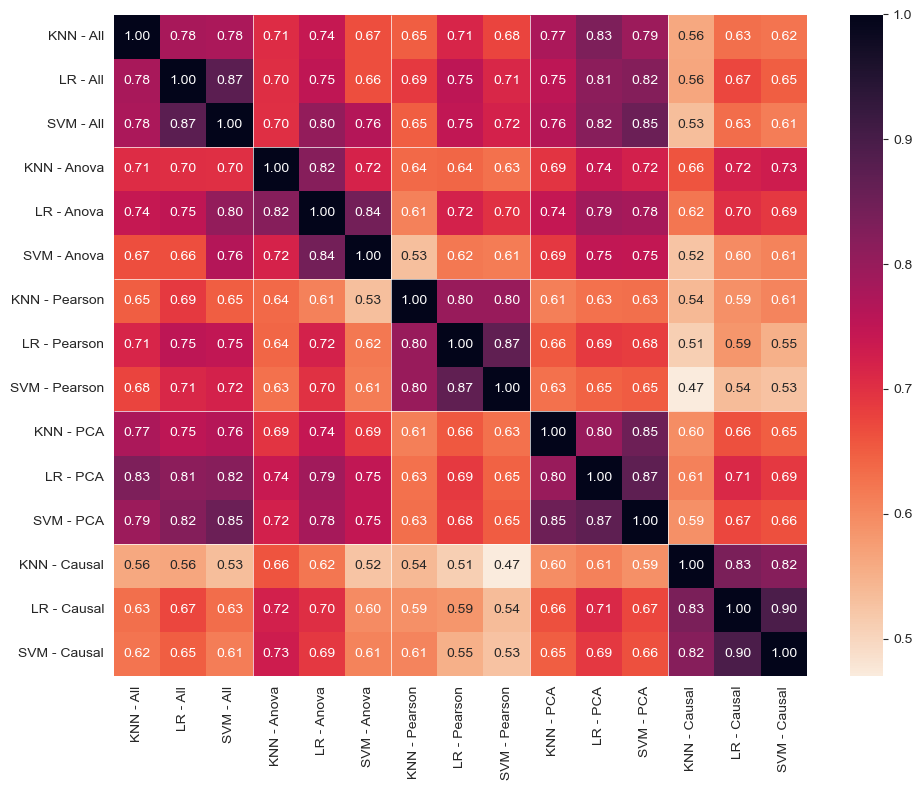

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(kappa_df, annot=True, fmt='.2f', cmap='rocket_r', ax=ax)

ax.hlines([3, 6, 9, 12], *ax.get_xlim(), colors='white', linewidth=.5)
ax.vlines([3, 6, 9, 12], *ax.get_xlim(), colors='white', linewidth=.5)

plt.tight_layout()
plt.savefig('images/cohen_kappa.png', dpi=300)